In [759]:
import sys
sys.path.append('../')

In [760]:
import pennylane as qml 
from pennylane import numpy as np 
import matplotlib.pyplot as plt 
from main import VarFourier

In [761]:
class interpolation():
    def __init__(self, base_ansatz, extra_qubits) -> None:
        self.base_ansatz = base_ansatz
        self.extra_qubits = extra_qubits
        self.num_qubits_tot = self.base_ansatz.num_qubits + self.extra_qubits
        self.num_params = self.base_ansatz.num_params

    
    def construct_circuit(self, params):
        
        # Make previous circuit
        self.base_ansatz.construct_circuit(params)
        
        qml.Barrier()

        # now we transform to momentum space
        QFT( self.num_qubits_tot , n_init=self.extra_qubits )
        #qml.QFT(range(self.extra_qubits,self.num_qubits_tot))
        qml.Barrier()
        # we entangle everything
        last_qubit_prev = self.base_ansatz.num_qubits - 1
        
        for wire in range(0,self.extra_qubits):
            #qml.CNOT([self.num_qubits_tot-1, wire])
            qml.SWAP([wire,self.num_qubits_tot +wire - self.extra_qubits -1])
            qml.CNOT([self.num_qubits_tot-1,self.num_qubits_tot +wire - self.extra_qubits -1])
            #pass

        
        # and finnaly we undo the QFT
        
        qml.Barrier()
        QFT(self.num_qubits_tot, inverse = True, n_init=0)
        #qml.adjoint( qml.QFT( range(self.num_qubits_tot) ) )


def QFT(n_wires_tot, semi_classical=False, inverse=False, n_init=0):
    n_wires = n_wires_tot
    if semi_classical:
        mid_measures = []
        for n in range( n_init, n_wires ):
            qml.Hadamard( wires=n )
            if n < n_wires-1:
                mid_measure = qml.measure( wires=n ) 
                mid_measures.append( mid_measure )
                for m in range(1,n_wires-n):
                    qml.cond( mid_measure, 
                                qml.PhaseShift )( np.pi/2**m, 
                                            wires=n+m ) 
    else:

        if inverse:
            for n in reversed(range( n_init , n_wires )):
                for m in reversed(range(1,n_wires-n)):
                    qml.ControlledPhaseShift( -np.pi/2**(m), 
                                                wires=[n,n+m]  )
                    #print(f'm = {m}')
                qml.Hadamard(wires=n)

        else:
            for n in range( n_init , n_wires ):
                qml.Hadamard(wires=n)
                for m in range(1,n_wires-n):
                    qml.ControlledPhaseShift( np.pi/2**(m), 
                                                wires=[n,n+m]  )
                    #print(f'm = {m}')


In [762]:
class RY_ansatz:
    def __init__( self, num_qubits, depth=1 , n_initial=0):
        self.n_initial = n_initial
        self.num_qubits = num_qubits - n_initial 
        self.depth = depth
        self.num_params = (num_qubits - n_initial ) * depth
    def construct_circuit( self, params ):
        params = np.array(params).reshape(self.depth,self.num_qubits)
        for layer, params_per_layer in enumerate(params):
            for wire in range(self.n_initial , self.num_qubits+self.n_initial):
                qml.RY(params_per_layer[wire-self.n_initial], wires=wire)
            if layer < len(params)-1:
                for wire in range(self.n_initial , self.num_qubits+self.n_initial-1):
                    qml.CNOT([wire,wire+1])
                #qml.CNOT([self.num_qubits-1,0]) 

In [955]:
num_qubits = 4

In [956]:
def init_state():
    #qml.AmplitudeEmbedding(features=vecs[:,0], wires=range(num_qubits))
    pass 

In [957]:
num_layers = 4
var_state_class = RY_ansatz(num_qubits, num_layers, n_initial=0)
#var_state_class = symmetric_ansatz(var_state_class)

#var_state_class = Rot_ansatz(num_qubits,num_layers)
#var_state_class = RY_ansatz(num_qubits,num_layers)
var_state = var_state_class.construct_circuit
num_params = var_state_class.num_params


(<Figure size 1400x500 with 1 Axes>, <Axes: >)

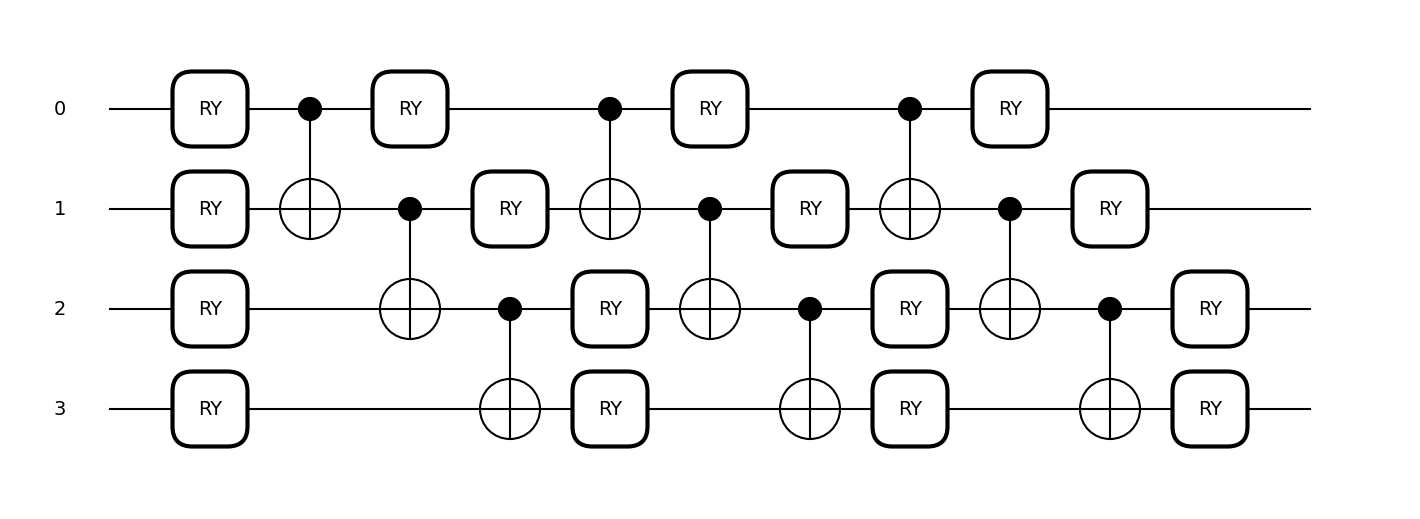

In [958]:
qml.draw_mpl( var_state )( num_params*[0] )

In [959]:
device = qml.device( "lightning.qubit", 
                    wires=num_qubits)

varqft = VarFourier( num_qubits,
                    lambda x : 0.5*(x**2),
                    lambda p : 0.5*(p**2),
                    device,
                    xmin=-5,
                    xmax=5,
                    var_state  = var_state,
                    init_state = init_state,
                    semi_classical=False
                    )

In [960]:
vals, vecs = varqft.energy_eigens()
val = vals[0]
vec = vecs[:,0]
vals

array([ 0.5       ,  1.49999995,  2.50000095,  3.49998774,  4.50010715,
        5.49925835,  6.50362063,  7.48406891,  8.5452919 ,  9.37927027,
       10.72366122, 11.30218389, 12.93629404, 14.11759416, 15.85728146,
       20.38719903])

In [961]:
beta = np.exp(-0.5*np.sqrt(np.abs(val)))/(2*np.sqrt(np.abs(val)))

In [962]:
beta

0.49652225020135193

In [963]:
1/16

0.0625

In [964]:
vals[3]/vals[0]

6.999975456517215

In [965]:
params_init = np.random.randn( num_params )*0.001
#params_pre = params_ground[-1]
#params_ground, energies_ground = varqft.run( np.concatenate((params_pre,np.random.randn(num_qubits)*1e-3)), max_iterations=500, learning_rate=0.5, conv_tol=1e-6 )
params_ground, energies_ground = varqft.run( params_init , max_iterations=300, learning_rate=0.2, conv_tol=1e-6 )

In [966]:
#params_init

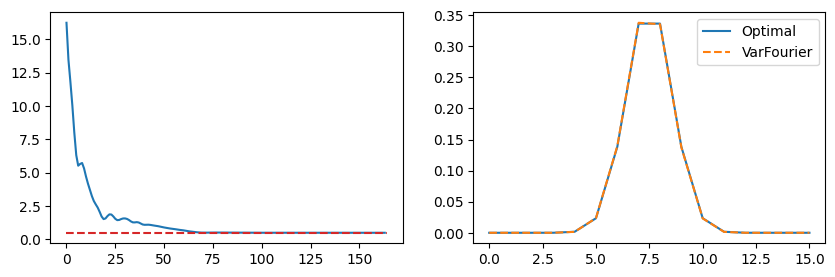

In [967]:
fig, ax = plt.subplots( 1, 2, figsize=(10,3) ) 

ax[0].plot( energies_ground )
ax[0].hlines( val, 0, len(energies_ground), colors='tab:red', linestyles='--' ) 

ground_state = varqft.state( params_ground[-1] )

ax[1].plot( np.abs(vecs[:,0])**2) 
ax[1].plot( np.abs(ground_state)**2, '--' ) 
ax[1].legend(['Optimal','VarFourier']) 

In [968]:
abs(np.vdot( ground_state, vec ))**2

0.9999468076631887

In [969]:
varqft.energy_eval(params_ground[-1])

Array(0.5003605, dtype=float32)

In [1010]:
num_layers = 4
extra = 3
var_state_class = RY_ansatz(num_qubits+extra, num_layers, n_initial=extra)

var_state_interpol = interpolation(var_state_class, extra_qubits=extra)

#var_state_class = Rot_ansatz(num_qubits,num_layers)
#var_state_class = RY_ansatz(num_qubits,num_layers)
var_state_interp = var_state_interpol.construct_circuit
#num_params = var_state_class.num_params


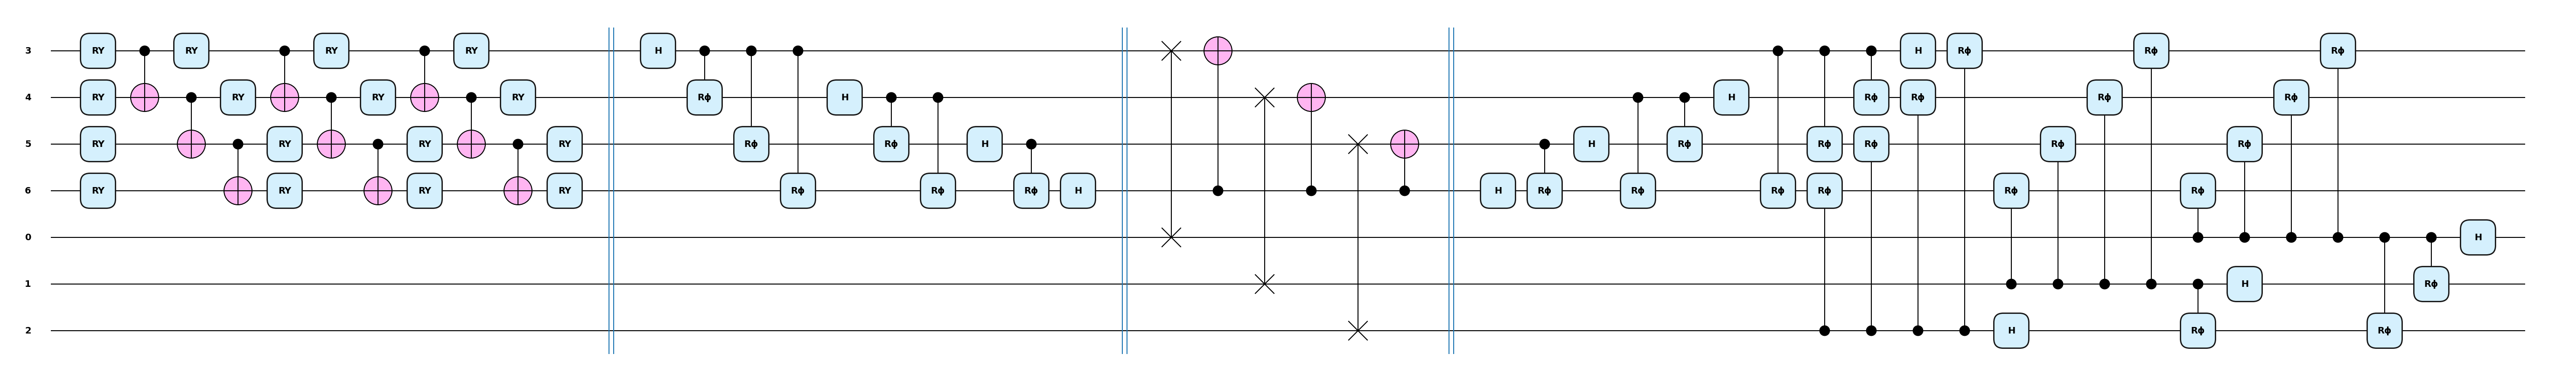

In [1011]:
fig, ax = qml.draw_mpl( var_state_interp , style='pennylane' )( params_ground[-1] )
fig.show()

In [1012]:
device2 = qml.device( "lightning.qubit", 
                    wires=num_qubits + extra)

varqft2 = VarFourier( num_qubits+extra,
                    lambda x : 0.5*(x**2),
                    lambda p : 0.5*(p**2),
                    device2,
                    xmin=-5,
                    xmax=5,
                    var_state  = var_state_interp,
                    init_state = init_state,
                    semi_classical=False
                    )

In [1013]:
vals2, vecs2 = varqft2.energy_eigens()
val2 = vals2[0]
vec2 = vecs2[:,0]
vals2

array([5.00000000e-01, 1.50000000e+00, 2.49999994e+00, 3.50000087e+00,
       4.49999003e+00, 5.50007348e+00, 6.49948204e+00, 7.50228398e+00,
       8.48866607e+00, 9.53012781e+00, 1.03928741e+01, 1.16851236e+01,
       1.21775051e+01, 1.41298442e+01, 1.43219328e+01, 1.69623187e+01,
       1.70452160e+01, 2.02035151e+01, 2.02481523e+01, 2.38504084e+01,
       2.38784868e+01, 2.78978626e+01, 2.79173337e+01, 3.23421446e+01,
       3.23565275e+01, 3.71807965e+01, 3.71918891e+01, 4.24122002e+01,
       4.24210223e+01, 4.80352669e+01, 4.80424440e+01, 5.40492449e+01,
       5.40551840e+01, 6.04536028e+01, 6.04585813e+01, 6.72479562e+01,
       6.72521701e+01, 7.44320216e+01, 7.44356138e+01, 8.20055862e+01,
       8.20086632e+01, 8.99684876e+01, 8.99711306e+01, 9.83206002e+01,
       9.83228719e+01, 1.07061826e+02, 1.07063775e+02, 1.16192086e+02,
       1.16193752e+02, 1.25711320e+02, 1.25712733e+02, 1.35619475e+02,
       1.35620661e+02, 1.45916511e+02, 1.45917489e+02, 1.56602395e+02,
      

In [1014]:
varqft2.energy_eval(params_ground[-1])

Array(0.54285634, dtype=float32)

In [1015]:
ground_state = varqft.state( params_ground[-1] )


In [1016]:
@qml.qnode(device2)
def get_state(params):
    var_state_interp(params)
    return qml.state()

In [1017]:
np.abs(vecs2[:,0])**2

tensor([1.80180504e-12, 2.38358708e-12, 3.88169277e-12, 7.14761481e-12,
        1.39859657e-11, 2.80489158e-11, 5.65795071e-11, 1.13728943e-10,
        2.26767551e-10, 4.47540617e-10, 8.73291890e-10, 1.68396317e-09,
        3.20802787e-09, 6.03696847e-09, 1.12213705e-08, 2.06017550e-08,
        3.73582142e-08, 6.69094567e-08, 1.18360349e-07, 2.06795531e-07,
        3.56854849e-07, 6.08215170e-07, 1.02385367e-06, 1.70228951e-06,
        2.79539885e-06, 4.53386861e-06, 7.26287966e-06, 1.14911508e-05,
        1.79569654e-05, 2.77151425e-05, 4.22489604e-05, 6.36106273e-05,
        9.45927976e-05, 1.38931652e-04, 2.01538986e-04, 2.88756438e-04,
        4.08619436e-04, 5.71111760e-04, 7.88384221e-04, 1.07490351e-03,
        1.44749069e-03, 1.92520425e-03, 2.52902186e-03, 3.28127850e-03,
        4.20482901e-03, 5.32191978e-03, 6.65277822e-03, 8.21395853e-03,
        1.00165163e-02, 1.20641197e-02, 1.43512362e-02, 1.68615588e-02,
        1.95668479e-02, 2.24263583e-02, 2.53869998e-02, 2.838433

In [1018]:
np.abs(get_state(params_ground[-1]))**2

tensor([8.30209004e-08, 4.44965176e-09, 2.37933566e-08, 1.22972480e-07,
        2.55641083e-07, 3.66542224e-07, 4.13004273e-07, 3.80085851e-07,
        2.83878563e-07, 1.62502644e-07, 5.92809855e-08, 5.41656897e-09,
        9.21318755e-09, 5.57003226e-08, 1.15910225e-07, 1.60980335e-07,
        1.74435201e-07, 1.57212781e-07, 1.23788169e-07, 9.26673280e-08,
        7.87060728e-08, 9.66191891e-08, 1.84034164e-07, 4.48982121e-07,
        1.14216573e-06, 2.75043476e-06, 6.10610095e-06, 1.25077140e-05,
        2.38514494e-05, 4.27771301e-05, 7.28374434e-05, 1.18701755e-04,
        1.86404606e-04, 2.83644884e-04, 4.20130964e-04, 6.07953523e-04,
        8.61950743e-04, 1.20000797e-03, 1.64321996e-03, 2.21581804e-03,
        2.94476794e-03, 3.85894137e-03, 4.98779165e-03, 6.35950547e-03,
        7.99865555e-03, 9.92348045e-03, 1.21429600e-02, 1.46539519e-02,
        1.74387041e-02, 2.04630550e-02, 2.36756243e-02, 2.70082299e-02,
        3.03776339e-02, 3.36886458e-02, 3.68384160e-02, 3.972163

In [1019]:
len(ground_state2)

64

In [1020]:
np.linspace(1.5,3.5,3)

tensor([1.5, 2.5, 3.5], requires_grad=True)

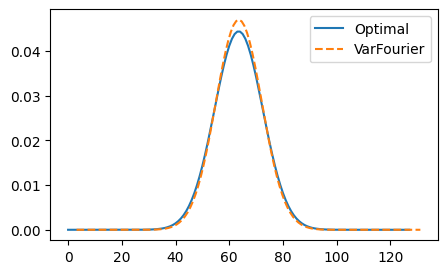

In [1021]:
fig, ax = plt.subplots( 1, 1, figsize=(5,3) ) 

ground_state2 = varqft2.state( params_ground[-1] )
extra=np.pi
ax.plot( np.abs(vecs2[:,0])**2) 
ax.plot(np.linspace(0+extra,128+extra,128) , np.abs(ground_state2)**2, '--' ) 
ax.legend(['Optimal','VarFourier']) 

In [877]:
2**6/2 -1

31.0